<a href="https://colab.research.google.com/github/iliailmer/ConvNet-Visualization/blob/master/FastAI_Lesson5_%2B_Fergus_Zeiler.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!wget https://boygeniusreport.files.wordpress.com/2016/11/puppy-dog.jpg?quality=98&strip=all

In [0]:
import torch
from torch import nn, optim
from torchvision.transforms import ToTensor, Compose,
from torchvision import models
from matplotlib import pyplot as plt
import numpy as  np

0it [00:00, ?it/s]

100%|█████████▉| 170254336/170498071 [01:54<00:00, 1620713.39it/s]

Files already downloaded and verified


In [0]:
net = models.alexnet()
net

In [0]:
!ls

In [0]:
class DeconvNet(nn.Module):
  def __init__(self, pretrained = True, *args, **kwargs):
    super().__init__(*args, **kwargs)
    net = models.alexnet(pretrained)
    if pretrained:
      for param in net.parameters():
        param.requires_grad = False
    self.conv2d_1 = net.features[0]
    self.relu_1 = net.features[1]
    self.pool_1 = net.features[2]
    self.pool_1.return_indices=True
    
    self.unpool_1 = nn.MaxUnpool2d(3,stride=2)
    self.deconv_1 = nn.ConvTranspose2d(64, 3, 
                                      kernel_size=11, 
                                      stride=4, 
                                      padding = 2, 
                                      bias=False)
    self.deconv_1.weight.data = self.conv2d_1.weight.data
    
    self.conv2d_2 = net.features[3]
    self.relu_2 = net.features[4]
    self.pool_2 = net.features[5]
    self.pool_2.return_indices=True
    
    self.unpool_2 = nn.MaxUnpool2d(3,stride=2)
    self.deconv_2 = nn.ConvTranspose2d(192, 64, 
                                      kernel_size=5, 
                                      stride=1, 
                                      padding = 2, 
                                      bias=False)
    self.deconv_2.weight.data = self.conv2d_2.weight.data
    
    self.conv2d_3 = net.features[6]
    self.relu_3 = net.features[7]
    
    self.deconv_3 = nn.ConvTranspose2d(384, 192, 
                                      kernel_size=3, 
                                      stride=1, 
                                      padding = 1, 
                                      bias=False)
    
    self.deconv_3.weight.data = self.conv2d_3.weight.data
    
    self.conv2d_4 = net.features[8]
    self.relu_4 = net.features[9]
    
    self.deconv_4 = nn.ConvTranspose2d(384, 256, 
                                      kernel_size=3, 
                                      stride=1, 
                                      padding = 1, 
                                      bias=False)
    self.deconv_4.weight.data = self.conv2d_4.weight.data

    self.conv2d_5 = net.features[10]
    self.relu_5 = net.features[11]
    self.pool_5 = net.features[12]
    self.pool_5.return_indices=True
    
    self.unpool_5 = nn.MaxUnpool2d(3,stride=2)
    self.deconv_5 = nn.ConvTranspose2d(256, 256, 
                                      kernel_size=3, 
                                      stride=1, 
                                      padding = 1, 
                                      bias=False)
    self.deconv_5.weight.data = self.conv2d_5.weight.data
    self.avg_pool = net.avgpool
    
    self.classifier = nn.Sequential(net.classifier, nn.Linear(1000,10))
    
    
    
    
    
  def forward(self, x):
    x = self.relu_1(self.conv2d_1(x))
    size_1 = x.size()
    x, idx_1 = self.pool_1(x)
    
    y_1 =self.deconv_1(self.relu_1(self.unpool_1(x, idx_1, output_size=size_1)))
    
    x = self.relu_2(self.conv2d_2(x))
    size_2 = x.size()
    x, idx_2 = self.pool_2(x)
    
    y_2 =self.deconv_2(self.relu_2(self.unpool_2(x, idx_2, output_size=size_2)))
    y_2 =self.deconv_1(self.relu_1(self.unpool_1(y_2, idx_1, output_size=size_1)))
    
    x = self.relu_3(self.conv2d_3(x))
    size_3 = x.size()
    y_3 =self.deconv_3(x)
    y_3 =self.deconv_2(self.relu_2(self.unpool_2(y_3, idx_2, output_size=size_2)))
    y_3 =self.deconv_1(self.relu_1(self.unpool_1(y_3, idx_1, output_size=size_1)))
    
    x = self.relu_4(self.conv2d_4(x))
    size_4 = x.size()
    
    y_4 =self.deconv_4(x)
    y_4 =self.deconv_3(y_4)
    y_4 =self.deconv_2(self.relu_2(self.unpool_2(y_4, idx_2, output_size=size_2)))
    y_4 =self.deconv_1(self.relu_1(self.unpool_1(y_4, idx_1, output_size=size_1)))
    
    
    x = self.relu_5(self.conv2d_5(x))
    size_5 = x.size()
    x, idx_5 = self.pool_5(x)
    y_5 =self.deconv_5(self.relu_2(self.unpool_2(x, idx_5, output_size=size_5)))
    y_5 =self.deconv_4(y_5)
    y_5 =self.deconv_3(y_5)
    y_5 =self.deconv_2(self.relu_2(self.unpool_2(y_5, idx_2, output_size=size_2)))
    y_5 =self.deconv_1(self.relu_1(self.unpool_1(y_5, idx_1, output_size=size_1)))
    
    
    x = self.avg_pool(x)
    x = self.classifier(x.view(-1,256*6*6))
    
    

    
    return x, (y_1, y_2, y_3, y_4, y_5)

net = DeconvNet().cuda()

In [0]:
import cv2

image = cv2.imread('puppy-dog.jpg?quality=98', )[:,:,::-1]
tfms = Compose([ToTensor()])
image = cv2.resize(image, (224,224))
image = tfms(image).view((-1,3,224,224))

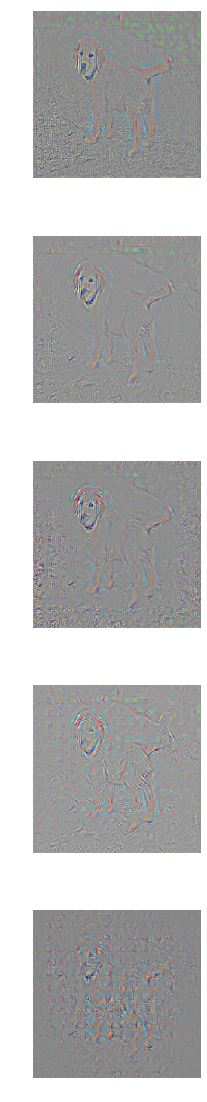

In [0]:
x = image.cuda()#trainloader.dataset[0][0].view((1,3,224,224)).cuda()
_, y = net(x)
def rescale(input):
  return (input - input.min())/(input.max()-input.min())
#plt.imshow(rescale(np.transpose(y4.detach().cpu().numpy()[0], (1,2,0))))

fig, ax = plt.subplots(nrows=5, ncols=1, figsize=(3,20))

for i, _ in enumerate(y):
    ax[i].imshow(rescale(np.transpose(y[i].detach().cpu().numpy()[0], (1,2,0))))
    ax[i].axis('off')